In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/motorica-skillfactory-intership-test-task-2024-10/sample_submission.csv
/kaggle/input/motorica-skillfactory-intership-test-task-2024-10/y_train.csv
/kaggle/input/motorica-skillfactory-intership-test-task-2024-10/X_test.npy
/kaggle/input/motorica-skillfactory-intership-test-task-2024-10/X_train.npy


# Модель распознавания жестов

## Импорт библиотек и сбор данных

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
#%matplotlib widget
# import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import optuna
from optuna.samplers import TPESampler
import warnings
import time

In [3]:
INPUT_DIR = '/kaggle/input/motorica-skillfactory-intership-test-task-2024-10/'
X_train_original = np.load(INPUT_DIR + 'X_train.npy')
X_test_original = np.load(INPUT_DIR + 'X_test.npy')

y_train_original = pd.read_csv(INPUT_DIR + 'y_train.csv')
#y_test = pd.read_csv('./y_test.csv')
y_test_original = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print('Структура обучающей и тестовой выборок:')
print(X_train_original.shape, y_train_original.shape)
print(X_test_original.shape, y_test_original.shape)

Структура обучающей и тестовой выборок:
(323, 40, 100) (32300, 2)
(54, 40, 100) (5400, 2)


In [4]:
print('Исходная структура с содержанием разметки наблюдений:')
y_train_original

Исходная структура с содержанием разметки наблюдений:


,sample-timestep,class
0,0-0,0
1,0-1,0
2,0-2,0
3,0-3,0
4,0-4,0
...,...,...
32295,322-95,4
32296,322-96,4
32297,322-97,4
32298,322-98,4


Мы видим, что исходя из предоставленной структуры данных требуется ее изменние в вид подходящий для моделей ML.

## Подготовка данных

В обучающем тергете ивлечем id и шаги наблюдений из поля sample-timestep.

In [5]:
y_train_original[['sample_id', 'timestep']] = y_train_original['sample-timestep'].str.split('-').to_list()
y_train_original['sample_id'] = y_train_original['sample_id'].astype('int')
y_train_original['timestep'] = y_train_original['timestep'].astype('int')
y_train_original = y_train_original.pivot(index='sample_id', columns='timestep', values='class')
y_train_original_index = y_train_original.index
y_train_original = y_train_original.sort_index() # на всякий случай
y_train_original = y_train_original.values
print('Новая структура обучающей выборки с целевым признаком:', y_train_original.shape)
y_train_original

Новая структура обучающей выборки с целевым признаком: (323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]])

In [6]:
y_test_original[['sample_id', 'timestep']] = y_test_original['sample-timestep'].str.split('-').to_list()
y_test_original['sample_id'] = y_test_original['sample_id'].astype('int')
y_test_original['y_test_original'] = y_test_original['timestep'].astype('int')
y_test_original = y_test_original.pivot(index='sample_id', columns='timestep', values='class')
y_test_original_index = y_test_original.index
y_test_original = y_test_original.sort_index() # на всякий случай
y_test_original = y_test_original.values
print('Новая структура тестовой выборки с целевым признаком:', y_test_original.shape)
y_test_original

Новая структура тестовой выборки с целевым признаком: (54, 100)


array([[0, 7, 0, ..., 1, 2, 8],
       [7, 3, 4, ..., 6, 7, 0],
       [0, 0, 5, ..., 3, 1, 5],
       ...,
       [5, 1, 1, ..., 1, 7, 3],
       [4, 0, 6, ..., 4, 7, 1],
       [5, 2, 2, ..., 0, 5, 1]])

## Разведывательный анализ данных

Визуализируем одно из наблюдений обучающей выборки, для того чтобы понимать его структуру.

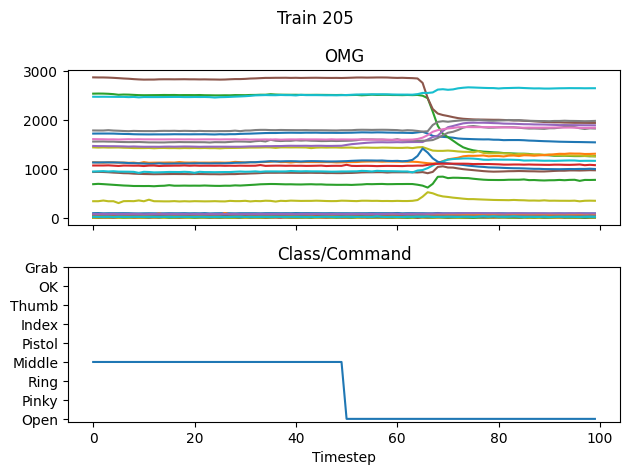

In [7]:
i = np.random.randint(X_train_original.shape[0])
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train_original[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train_original[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')
plt.tight_layout()

Визуализируем одно из наблюдений тестовой выборки.

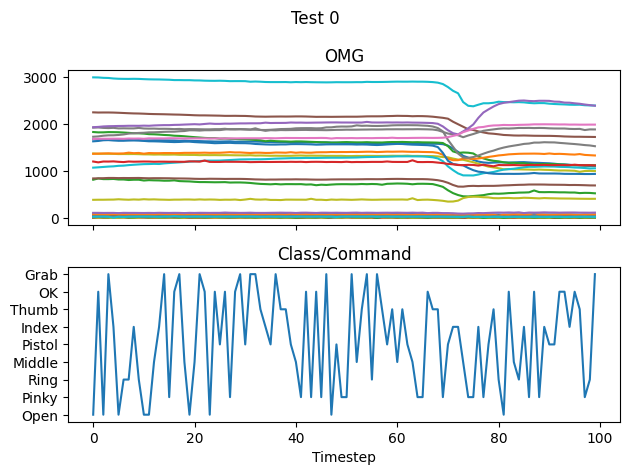

In [8]:
#i = np.random.randint(X_test_original.shape[0])
i = 0
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_test_original[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_test_original[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test {i}')
plt.tight_layout()

Видим, что в исходных признаках есть моменты времени, в которые пилот меняет положение кисти. Начиная с момента смены команды, в 50 шаг времени, и до окончания фазы смены положения кисти пилотом, примерно 80 шаг, в данный промежуток времени показания датчиков не соотвествуют целевому признаку. Тестовый таргет имеет случайные значения, его необходимо предсказать. 

## Очистка признаков и изменение структуры данных

Вырежем переходную фазу из обучающей выборки. 
Попутно мы приведем структуру учебной выборки вид пригодный для применения его в моделях ML. 

In [9]:
BEGIN_CHANGE_CLASS = 50
END_CHANGE_CLASS = 80
LEN_SAMPLE = X_train_original.shape[2]
def get_X_cleaned(X):
    lst_X = []
    for sample in range(X.shape[0]):
        lst_X.append(X[sample][:, :BEGIN_CHANGE_CLASS].T)
        lst_X.append(X[sample][:, END_CHANGE_CLASS:].T)
    return np.vstack(lst_X)

def get_y_cleaned(y):
    lst_y = []
    for sample in range(y.shape[0]):
        lst_y.append(np.array(y[sample][:BEGIN_CHANGE_CLASS]))
        lst_y.append(np.array(y[sample][END_CHANGE_CLASS:]))
    return np.hstack(lst_y)


X_train_cleaned = get_X_cleaned(X_train_original)
y_train_cleaned = get_y_cleaned(y_train_original)
print('Размерность обучающей выборки:')
X_train_cleaned.shape, y_train_cleaned.shape

Размерность обучающей выборки:


((22610, 40), (22610,))

Очистим наблюдения тестовой выборки от переходных фаз.

In [10]:
X_test_cleaned = get_X_cleaned(X_test_original)
y_test_cleaned = get_y_cleaned(y_test_original)
print('Размерность тествой выборкии:')
X_test_cleaned.shape, y_test_cleaned.shape

Размерность тествой выборкии:


((3780, 40), (3780,))

Визуализируем фрагмент учебной выборки после очистки наблюдений от переходных фаз и смены структуры.

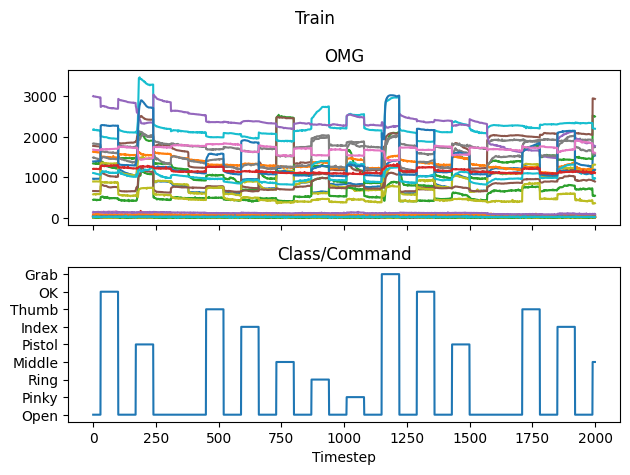

In [11]:
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train_cleaned[1000:3000])
axx[0].set_title('OMG')

axx[1].plot(y_train_cleaned[1000:3000])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train')

plt.tight_layout()

Теперь мы видим, что обучающая выборка готова для применения ее в мобучении моделей ML.

Визуализируем фрагмент тестовой выборки после очистки наблюдений от переходных фаз и смены структуры.

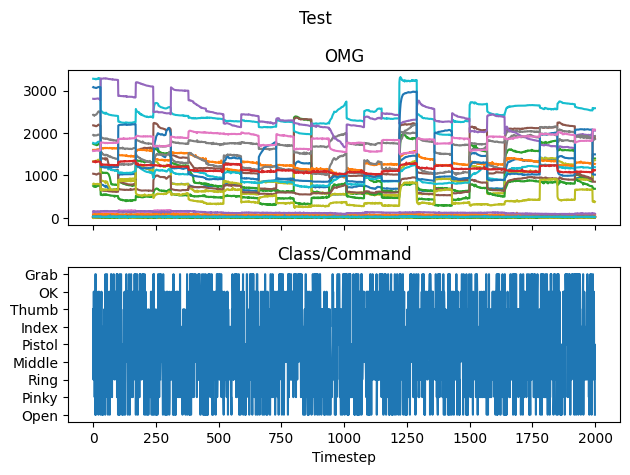

In [12]:
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_test_cleaned[1000:3000])
axx[0].set_title('OMG')

axx[1].plot(y_test_cleaned[1000:3000])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test')

plt.tight_layout()

Тестовая выборка готова для предсказаний.

## Построение моделей ML

Визуализируем размерноть классов в полученной учебной выборке для понимания того, нужно ли вычислять отдельные веса для классов при обучении моделей ML.

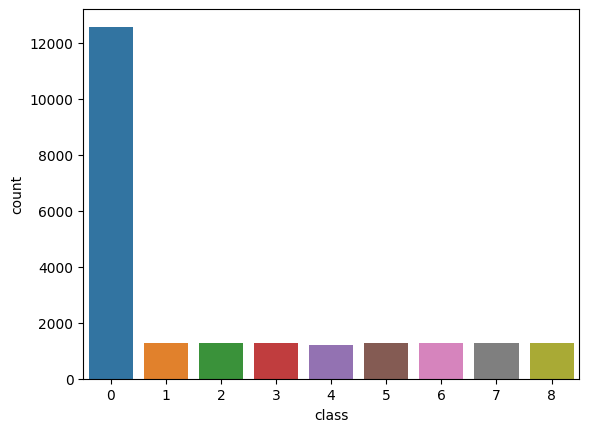

In [13]:
df_y_train_cleaned = pd.DataFrame({'class': y_train_cleaned})
sns.countplot(data=df_y_train_cleaned, x='class');

Мы видим,что основную долю составляет класс 0 - команда "Open". Поэтому данному классу необходимо присвоить наименьший вес при обучении. Остальные классы имеют примерно обдинаковую долю. Вычислим веса для каждого класса, и положим их в соотвествующую  структуру. 

In [14]:
weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_train_cleaned),
                                                 y=y_train_cleaned)
class_weights = dict([(class_, weights[class_]) for class_ in 
                      np.unique(y_train_cleaned)])
print('Веса классов:')
class_weights

Веса классов:


{0: 0.1996996996996997,
 1: 1.9938271604938271,
 2: 1.9938271604938271,
 3: 1.9938271604938271,
 4: 2.076216712580349,
 5: 1.9938271604938271,
 6: 1.9938271604938271,
 7: 1.9938271604938271,
 8: 1.9938271604938271}

Разделим обучующую имеющую таргет на обучающую и тестовую со стратификацией таргета.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_cleaned, y_train_cleaned, stratify=y_train_cleaned, test_size=0.25, random_state=42)

Объявим вспомогательную функцию для получения метрик.

In [16]:
def get_metrics(data_true, data_pred):
  param = {'average': 'weighted'}
  metric_funcs = {accuracy_score: ['accuracy', {}],  
                  f1_score: ['f1', param],
                  precision_score: ['precision', param],
                  recall_score: ['recall', param]
                  }
  return [(metric_funcs[func][0], func(data_true, data_pred, 
                                       **metric_funcs[func][1])) for func in metric_funcs]

Объявим вспомогательную функцию проведения кросс-валидации.

In [17]:
def get_score_cross_validate(model, X_train, y_train, n_splits=5):
    f1_scorer = make_scorer(f1_score, average='weighted')
    #Создаём объект кросс-валидатора StratifiedKFold
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    #Считаем метрики на кросс-валидации k-fold
    cv_metrics = cross_validate(
        estimator=model, #модель
        X=X_train, #матрица наблюдений X
        y=y_train, #вектор ответов y
        cv=kf, #кросс-валидатор
        scoring=f1_scorer, #метрика
        return_train_score=False #подсчёт метрики на тренировочных фолдах
    )
    score = np.mean(cv_metrics['test_score'])
    return score

Объявим целевые функции, отдельно для каждой модели ML. В целевых функциях заданы области для поиска гиперпараметров, происходит инициализация модели по входящему в функцию параметру, далее выполняется валидация на основе обучающей выборки, и выдается средняя метрика.

In [18]:
def optuna_LogisticRegressionr(trial):
            # задаем пространства поиска гиперпараметров
            model_params =  {
                'penalty': trial.suggest_categorical("penalty",
                          ['l2', None]),
                'solver': trial.suggest_categorical("solver",
                          ['newton-cg', 'sag', 'saga', 'lbfgs']),
                "C": trial.suggest_float("C", 0.001, 10, log=False),
                'multi_class': trial.suggest_categorical("multi_class", ['multinomial']),
                'max_iter': trial.suggest_int("max_iter", 1000, 1000),
                'class_weight': trial.suggest_categorical("class_weight", [class_weights]),
                #'n_jobs': trial.suggest_int("n_jobs", -1, -1), 
                'random_state': trial.suggest_int("random_state", 42, 42),
                'verbose': trial.suggest_int("verbose", 0, 0)  
            }
            # создаем модель
            model = LogisticRegression(**model_params)
            # запускаем валидацию обучающей выбоки
            score = get_score_cross_validate(model, X_train, y_train)
            return score

In [19]:
def optuna_RandomForestClassifier(trial):
            # задаем пространства поиска гиперпараметров
            model_params =  {           
                'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
                "max_depth": trial.suggest_int("max_depth", 3, 15),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 64),
                'class_weight': trial.suggest_categorical("class_weight", [class_weights]),
                #'n_jobs': trial.suggest_int("n_jobs", -1, -1), 
                'random_state': trial.suggest_int("random_state", 42, 42),
                'verbose': trial.suggest_int("verbose", 0, 0)              
            }
            # создаем модель
            model = RandomForestClassifier(**model_params)
            # запускаем валидацию обучающей выбоки
            score = get_score_cross_validate(model, X_train, y_train)
            return score

In [20]:
def optuna_CatBoostClassifier(trial):
            # задаем пространства поиска гиперпараметров
            model_params =  {
                #'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
                'iterations': trial.suggest_int('iterations', 10, 1000),
                "depth": trial.suggest_int("depth", 3, 12),
                #'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
                #'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 0, 8),
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 64),
                #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=False),
                'task_type': trial.suggest_categorical("task_type", ['GPU']),
                'devices': trial.suggest_categorical("devices", ['0']),
                'loss_function': trial.suggest_categorical("loss_function", ['MultiClass']),
                'class_weights': trial.suggest_categorical("class_weights", [class_weights]),
                'random_state': trial.suggest_int("random_state", 42, 42),
                'verbose': trial.suggest_int("verbose", 0, 0)  
            }
            # создаем модель
            model = CatBoostClassifier(**model_params)
            # запускаем валидацию обучающей выбоки
            score = get_score_cross_validate(model, X_train, y_train)
            return score

In [21]:
def optuna_SVC(trial):
            # задаем пространства поиска гиперпараметров
            model_params =  {
                'C': trial.suggest_float('C', 0.1, 1000, log=False),
                'gamma': trial.suggest_float('gamma', 0.0001, 1, log=False),
                'kernel': trial.suggest_categorical('kernel', ['rbf','linear']),
                'class_weight': trial.suggest_categorical("class_weight", [class_weights]),
                #'n_jobs': trial.suggest_int("n_jobs", -1, -1), 
                'random_state': trial.suggest_int("random_state", 42, 42),
                'verbose': trial.suggest_int("verbose", 0, 0)  
            }
            # создаем модель
            model = SVC(**model_params)
            # запускаем валидацию обучающей выбоки
            score = get_score_cross_validate(model, X_train, y_train)
            return score

Приступим непосредственно к поиску оптимальных гиперпараметров множества моделей ML. Метод optuna.study.Study.optimize вызывается циклом, для каждой модели. Данный метод вызывает целевую функцию заданное кол-во раз. Оптимальные гиперпараметры, отобранные встроенным в Optune байесовский алгоритмом, который учитывает результаты предыдущих вызовов функции, передаются в целевую функцию. По результатам работы процесса оптимизации мы получаем оптимальные гиперпараметры для каждой модели и сохраняем их отдельную структуру для моделей.

In [22]:
print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 4.0.0


In [23]:
# Отключаем предупреждения  
warnings.filterwarnings("ignore")
# Создадим структуру моделей для хранения ссылок
# на целевые функции оптимизации гиперпараметров,
# найденных оптимальных гиперпараметров и
# выборок с прогнозами моделей
models_ML = {
    LogisticRegression.__name__: {'model': LogisticRegression, 
                                'func': optuna_LogisticRegressionr},
    RandomForestClassifier.__name__: {'model': RandomForestClassifier, 
                                'func': optuna_RandomForestClassifier},
    CatBoostClassifier.__name__: {'model': CatBoostClassifier,
                                'func': optuna_CatBoostClassifier},
    SVC.__name__: {'model': SVC, 'func': optuna_SVC}
    }
# Запустим цикл оптимизации гиперпараметров моделей
sampler = TPESampler(seed=42)
optuna.logging.set_verbosity(optuna.logging.WARNING)
for model_ML in models_ML:
    print('Поиск оптимальных гиперпараметров: ', model_ML)
    study = optuna.create_study(direction='maximize', study_name=model_ML, sampler=sampler)
    study.optimize(models_ML[model_ML]['func'], n_trials=10, #n_jobs=-1,
                   show_progress_bar=True)
    # Сохраним оптимальные гиперпараметры модели в структуру моделей
    models_ML[model_ML]['best_params'] = study.best_trial.params

Поиск оптимальных гиперпараметров:  LogisticRegression


  0%|          | 0/10 [00:00<?, ?it/s]

Поиск оптимальных гиперпараметров:  RandomForestClassifier


  0%|          | 0/10 [00:00<?, ?it/s]

Поиск оптимальных гиперпараметров:  CatBoostClassifier


  0%|          | 0/10 [00:00<?, ?it/s]

Поиск оптимальных гиперпараметров:  SVC


  0%|          | 0/10 [00:00<?, ?it/s]

Сделаем прогноз циклом всеми моделями с оптимальными гиперпараметрами, получим метрики на основании обучающей и тестовой выборок. Сформируем итоговую таблицу по всем моделям.

In [24]:
# Создадим заготовку итоговой таблицы
data_result = pd.DataFrame({'Модель': '', ('Время обучения', ''): []}).set_index('Модель')
# Запустим цикл обучения и получения метрик
for model_ML in models_ML:
    best_params = models_ML[model_ML]['best_params']
    model = models_ML[model_ML]['model'](**best_params)
    # Обучим модель
    start_time = time.time()
    model.fit(X_train, y_train)
    duration_fit_ML = time.time() - start_time
    # Сохраним продолжительность обучения модели в таблицу итоговых результатов
    data_result.loc[model_ML, [('Время обучения', '')]] = duration_fit_ML
    # Сделаем предсказание обучающей выборки
    y_pred_train = model.predict(X_train)
    # Сохраним обучающие метрики в таблице итоговых результатов
    metrics = get_metrics(y_train, y_pred_train)
    data_result.loc[model_ML, [('Обучающие метрики', metric[0])
                       for metric in metrics]] = [metric[1] for metric in metrics]
    # Сделаем предсказание тестовой выборки
    y_pred_test = model.predict(X_test)
    # Сохраним тестовые метрики в таблице итоговых результатов
    metrics = get_metrics(y_test, y_pred_test)
    data_result.loc[model_ML, [('Тестовые метрики', metric[0])
                       for metric in metrics]] = [metric[1] for metric in metrics]
    # Сохраним обученную модель в структуру model_ML
    models_ML[model_ML]['model_fitted'] = model
data_result.columns = pd.MultiIndex.from_tuples(data_result.columns)
print('Итоговая таблица по моделям:')
data_result

Итоговая таблица по моделям:


Время обучения Обучающие метрики                      \
                                               accuracy        f1 precision   
Модель                                                                        
LogisticRegression          10.385341          1.000000  1.000000  1.000000   
RandomForestClassifier      46.627444          0.999115  0.999115  0.999118   
CatBoostClassifier           0.832391          1.000000  1.000000  1.000000   
SVC                          0.199303          1.000000  1.000000  1.000000   

                                 Тестовые метрики                      \
                          recall         accuracy        f1 precision   
Модель                                                                  
LogisticRegression      1.000000         1.000000  1.000000  1.000000   
RandomForestClassifier  0.999115         0.998939  0.998938  0.998945   
CatBoostClassifier      1.000000         0.999469  0.999469  0.999475   
SVC                     1.000000         0.999823  0.999823  0.999824   

                                  
                          recall  
Модель                            
LogisticRegression      1.000000  
RandomForestClassifier  0.998939  
CatBoostClassifier      0.999469  
SVC                     0.999823

# Предсказание наилучшей моделью

Выберем наилучшую модель по тестовой метрике F1.

In [25]:
model_name = data_result['Тестовые метрики']['f1'].sort_values(ascending=False).index[0]
model = models_ML[model_name]['model_fitted']
print('Обученная модель с лучшей тестовой метрикой f1:\n', model)

Обученная модель с лучшей тестовой метрикой f1:
 LogisticRegression(C=9.65635469871252,
                   class_weight={0: 0.1996996996996997, 1: 1.9938271604938271,
                                 2: 1.9938271604938271, 3: 1.9938271604938271,
                                 4: 2.076216712580349, 5: 1.9938271604938271,
                                 6: 1.9938271604938271, 7: 1.9938271604938271,
                                 8: 1.9938271604938271},
                   max_iter=1000, multi_class='multinomial', random_state=42)


Сделаем предсказание таргета на основе тестовой выборки.

In [26]:
y_test_pred_cleaned = model.predict(X_test_cleaned)
print('Размерность предсказаний:')
y_test_pred_cleaned.shape

Размерность предсказаний:


(3780,)

Визуализируем фрагмент тестовой выборки после предсказания таргета.

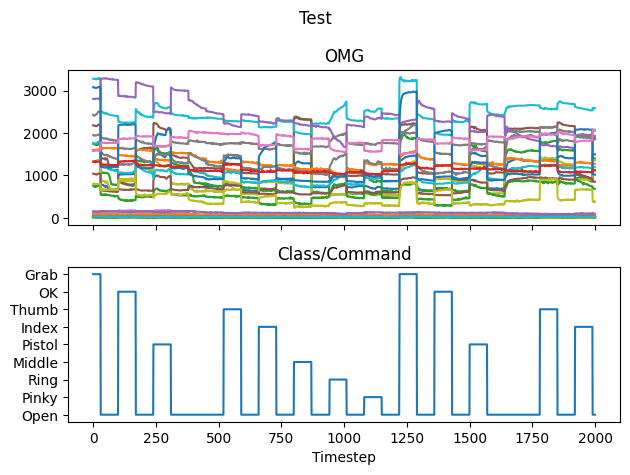

In [27]:
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_test_cleaned[1000:3000])
axx[0].set_title('OMG')

axx[1].plot(y_test_pred_cleaned[1000:3000])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test')

plt.tight_layout()

# Смена структуры предсказаний для сабмита

Для начала приведем структуру тестовой выборки в удобный вид для визуализации отдельных наблюдений. 

In [28]:
LEN_SAMPLE_CLEARED = BEGIN_CHANGE_CLASS + (LEN_SAMPLE - END_CHANGE_CLASS)
LEN_SAMPLE, LEN_SAMPLE_CLEARED

(100, 70)

In [29]:
lst_y = []
for index in range(0, y_test_pred_cleaned.shape[0], LEN_SAMPLE_CLEARED):
    left_class = stats.mode(y_test_pred_cleaned[index:index + BEGIN_CHANGE_CLASS])[0]
    right_class = stats.mode(y_test_pred_cleaned[index+BEGIN_CHANGE_CLASS:index+LEN_SAMPLE_CLEARED])[0]
    sampe_test_pred = np.array([left_class] * 50 + [right_class] * 50)
    lst_y.append(sampe_test_pred)
    #print(index, left_class, right_class)
y_test_pred = np.vstack(lst_y)
y_test_pred.shape

(54, 100)

In [30]:
lst = []
for index in range(0, X_test_cleaned.shape[0], LEN_SAMPLE_CLEARED):
    lst.append(X_test_cleaned[index: index + BEGIN_CHANGE_CLASS])
    lst.append(np.zeros((LEN_SAMPLE-LEN_SAMPLE_CLEARED, 40)))
    lst.append(X_test_cleaned[index + BEGIN_CHANGE_CLASS: 
                              index+LEN_SAMPLE_CLEARED])
X_test_insert_zeros = np.vstack(lst)

In [31]:
X_test_insert_zeros_reshape = np.vstack([X_test_insert_zeros[index: index + LEN_SAMPLE].T for index in range(
    0, X_test_insert_zeros.shape[0], LEN_SAMPLE)])
X_test_insert_zeros_reshape = X_test_insert_zeros_reshape.reshape(X_test_original.shape[0],40,LEN_SAMPLE)
X_test_insert_zeros_reshape.shape

(54, 40, 100)

Визуализируем фрагмент тестовой выборки после предсказания таргета.

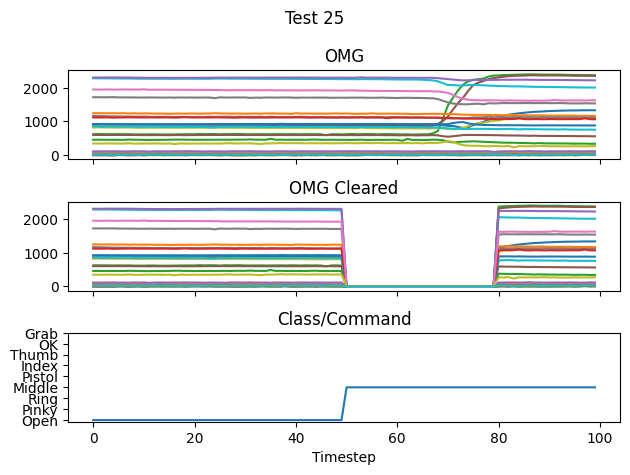

In [32]:
i = np.random.randint(X_test_original.shape[0])
fig, axx = plt.subplots(3, 1, sharex=True)
    
axx[0].plot(X_test_original[i].T)
axx[0].set_title('OMG')

axx[1].plot(X_test_insert_zeros_reshape[i].T)
axx[1].set_title('OMG Cleared')

axx[2].plot(y_test_pred[i])

axx[2].set_title('Class/Command')
axx[2].set_xlabel('Timestep')
axx[2].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test {i}')

plt.tight_layout()

Приведем структуру таргета в необходимый вид для сабмита.

In [33]:
df_y_test = []
for idx, arr in zip(y_test_original_index, y_test_pred):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    df_y_test.append(series)
    
df_y_test = pd.concat(df_y_test)
df_y_test = df_y_test.reset_index()
df_y_test.columns = ["sample-timestep", "class"]
df_y_test

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4
...,...,...
5395,376-95,4
5396,376-96,4
5397,376-97,4
5398,376-98,4


Выведем количество предсказанных классов.

In [34]:
df_y_test['class'].value_counts().sort_index()

class
0    3000
1     300
2     300
3     300
4     300
5     300
6     300
7     300
8     300
Name: count, dtype: int64

Сохраним итоговую структуру предсказанного таргета в файл.

In [35]:
#y_test['class'] = 0
df_y_test.to_csv('./y_test_predicted.csv', index=False)